<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Ripples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google import colab
from tqdm import tqdm
import h5py

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter
!pip install --upgrade pyabf
import pyabf


clear_output()


In [12]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    return new_filename




data_source = "https://www.dropbox.com/sh/cz03im6sa98nquz/AAB-WXnlE4jdTp37CiwVPUCLa?dl=0"
data_name = 'rip_data'
file_loc = get_drobox_folder(data_source, data_name)
file_list = []
for (root, dirs, file) in os.walk(file_loc):
    for f in file:
        if ".abf" in f:
            file_list.append(os.path.join(root,f))


clear_output()


In [13]:
####### MATH
def z_trans_2(x):
    x_mean = np.expand_dims(np.mean(x,axis=1),1)
    x_std = np.expand_dims(np.std(x,axis=1),1)
    x_z = (x - x_mean) / x_std
    return x_z

def z_trans(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_z = (x - x_mean) / x_std
    return x_z

def mov_mean(x,stride):
    x_mm = np.convolve(x,np.ones(stride),'same')/stride
    return x_mm

In [14]:
file_list = []

dates_to_analyze = ['2023x07x06','2023x07x07_E3KI','2023x07x13','2023x07x12','2023x07x14','2023x07x17']
for (rt,dr,files) in os.walk('/content/rip_data/'):
    for f in files:
        for d in dates_to_analyze:
            if d in f and '.abf' in f[-4:]:
                file_list.append(os.path.join(rt,f))

file_list.sort()
clear_output()
print(len(file_list))

41


In [17]:
### Match Recs and Notes
rip_notes = pd.read_csv('/content/rip_data/Ripples - Sheet1.csv') # .set_index('Slice_Code')
keep_rows = []
for r in rip_notes.index:
    sl = str(rip_notes.loc[r,'Slice_Code'])
    check_slice = any([sl in f for f in file_list])
    if check_slice: keep_rows.append(True)
    else: keep_rows.append(False)
rip_notes = rip_notes[keep_rows]


for r in rip_notes.index:
    sl = rip_notes.loc[r,'Slice_Code']
    number =rip_notes.loc[r,'rec']
    if not np.isnan(number):    rec_str = f"{int(number):04d}"
    else:    rec_str = 'nan'
    slice_code_plus = sl+ '_' + rec_str
    rip_notes.at[r,'slice_code_plus']=slice_code_plus
rip_notes = rip_notes.set_index('slice_code_plus')



rip_df = pd.DataFrame(index=file_list)

chan_list = ['ch_0','ch_1']
for c in chan_list:
    rip_df[c]=np.nan
    rip_df[c] = rip_df[c].astype('object')



for f in rip_df.index:
    f_slice = os.path.basename(f)[:-4]
    if f_slice in rip_notes.index:
        # print(f_slice)
        # print(rip_notes.loc[f_slice,'epoch_0'])
        rip_df.at[f,'epoch_0'] = rip_notes.loc[f_slice,'epoch_0']
        rip_df.at[f,'epoch_1'] = rip_notes.loc[f_slice,'epoch_1']


rip_df_keep = []
for f in rip_df.index:
    f_slice = os.path.basename(f)[:-4]
    rip_df_keep.append(f_slice in rip_notes.index)
rip_df=rip_df[rip_df_keep]


### convert to HDF
for f in rip_df.index:
    row_series = (rip_df.loc[f]).to_frame().transpose()
    key_f = f.replace('/',"")
    base_f = os.path.basename(f)[:-4]
    row_series.to_hdf(f'{base_f}.h5',key=key_f)

def get_keys(data_name='LFP_Data.h5'):
    hf = h5py.File('LFP_Data.h5', 'r')
    hf_keys = list(hf.keys())
    hf.close()
    return hf_keys
print( get_keys() )

In [19]:
def time_bands(abf,sweepNumber=0,channel=0,order = 4):
    fs = abf.sampleRate
    abf.setSweep(sweepNumber=sweepNumber,channel=channel)
    v_trace = abf.sweepY
    time = abf.sweepX

    new_fs = 1000
    ds_factor = np.ceil(fs/new_fs)
    v_trace_1khz = v_trace[::int(ds_factor)]
    time_1khz = time[::int(ds_factor)]

    b, a = scipy.signal.butter(order, [0.7,300], btype='bandpass',fs=new_fs)
    wide_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

    b, a = scipy.signal.butter(order, [150,250], btype='bandpass',fs=new_fs)
    ripple_band = scipy.signal.filtfilt(b, a, wide_band)

    b, a = scipy.signal.butter(order, [15 ,50], btype='bandpass',fs=new_fs)
    slow_gamma_band = scipy.signal.filtfilt(b, a, wide_band)

    b, a = scipy.signal.butter(order, [1 ,20], btype='bandpass',fs=new_fs)
    sharp_wave_band = scipy.signal.filtfilt(b, a, wide_band)

    freq_bands = {'fs':new_fs,
                  'time_1khz':time_1khz,
                  'wide_band':wide_band,
                  'sharp_wave_band':sharp_wave_band,
                  'ripple_band':ripple_band,
                  'slow_gamma_band':slow_gamma_band,
                  }

    for k in freq_bands.keys():
        if 'band' in k:
                amplitude_envelope = np.abs(scipy.signal.hilbert(freq_bands[k]))
                freq_bands[k] = {'lfp': freq_bands[k], 'hilb_env':amplitude_envelope}

    return freq_bands



for f in tqdm( rip_df.index ):
    key_f = f.replace('/',"")
    base_f = os.path.basename(f)[:-4]
    rec_entry = pd.read_hdf(f'{base_f}.h5',key=key_f)
    abf = pyabf.ABF(f)
    rec_entry.at[f,'ch_0'] = time_bands(abf,sweepNumber=0,channel=0)
    rec_entry.at[f,'ch_1'] = time_bands(abf,sweepNumber=0,channel=1)
    rec_entry.to_hdf(f'{base_f}.h5',key=key_f)


100%|██████████| 30/30 [03:05<00:00,  6.17s/it]


In [7]:
# colab.files.download('/content/LFP_Data.h5')

In [20]:
""" Parse Epochs """
for k in tqdm( get_keys() ):
    key_f = f.replace('/',"")
    base_f = os.path.basename(f)[:-4]
    rec_entry = pd.read_hdf(f'{base_f}.h5',key=key_f)


    epoch_list = ['ep_0_inds','ep_1_inds']
    for e in epoch_list:
        rec_entry[e] = np.nan
        rec_entry[e] = rec_entry[e].astype('object')

    epoch_0_tag = rec_entry.loc[f,'epoch_0']
    epoch_0_time = epoch_0_tag.split(' ')[1]

    if ':' in epoch_0_time: int(epoch_0_time.split(':')[0]*60 + epoch_0_time.split(':')[1] ) #mm:ss > sss

    epoch_1_tag = rec_entry.loc[f,'epoch_1']
    if isinstance(epoch_1_tag,str):
        epoch_1_time = epoch_1_tag.split(' ')[1]
        if ':' in epoch_1_time: epoch_1_time =  int( epoch_1_time.split(':')[0])*60 + int(epoch_1_time.split(':')[1] )
    else:
        epoch_1_time = np.nan

    # epoch indicies
    fs = rec_entry.loc[f,'ch_0']['fs']
    time = rec_entry.at[f,'ch_0']['time_1khz']
    if np.isnan(epoch_1_time):
        rec_entry.at[f,'ep_0_inds'] = np.arange(0,len(time))
    else:
        rec_entry.at[f,'ep_0_inds'] = np.arange(0, epoch_1_time*fs)
        rec_entry.at[f,'ep_1_inds'] = np.arange(epoch_1_time*fs,len(time))

    rec_entry.to_hdf(f'{base_f}.h5',key=key_f)




100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


In [9]:
# colab.files.download('/content/LFP_Data.h5')

In [21]:
def triggered_inds(trace,fs,sd_thresh= 3,min_dur_ms= 5,peak_wind_ms=20):
    ''' trigger on crossing'''
    trig_bool = z_trans(trace)>sd_thresh
    min_dur_tic = int(min_dur_ms*fs/1000)
    trig_bool = mov_mean(trig_bool,min_dur_tic)==1
    trigs = np.arange(len(trig_bool))[np.diff(trig_bool,prepend=0)==1]

    ''' allign peaks'''
    tick_range = peak_wind_ms/1000*fs
    peak_window_tics = np.arange(0,tick_range,dtype=int)
    trig_alligned = []
    max_tick = len(trace)
    for t in trigs:
        if (t+peak_window_tics[0])>=0 and (t+peak_window_tics[-1])<max_tick:
            sub_trace = trace[t+peak_window_tics]
            peak_tick = np.where(sub_trace==np.max(sub_trace))[0][0]
            trig_alligned.append(t+peak_tick-np.min(peak_window_tics))
    trig_alligned=np.array(trig_alligned)

    return trig_alligned





trig_bands = ['ripple_band','sharp_wave_band','slow_gamma_band']

for k in tqdm( get_keys() ):
    key_f = f.replace('/',"")
    base_f = os.path.basename(f)[:-4]
    rec_entry = pd.read_hdf(f'{base_f}.h5',key=key_f)

    for ch in chan_list:
        filtered = rec_entry.loc[f,ch]
        for b in trig_bands:
            trace = filtered[b]['hilb_env']
            fs = filtered['fs']
            trigs = triggered_inds(trace,fs)
            filtered[b]['trigs'] = trigs
            # print(len(trigs))
        rec_entry.at[f,ch] =filtered
        rec_entry.to_hdf(f'{base_f}.h5',key=key_f)





100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

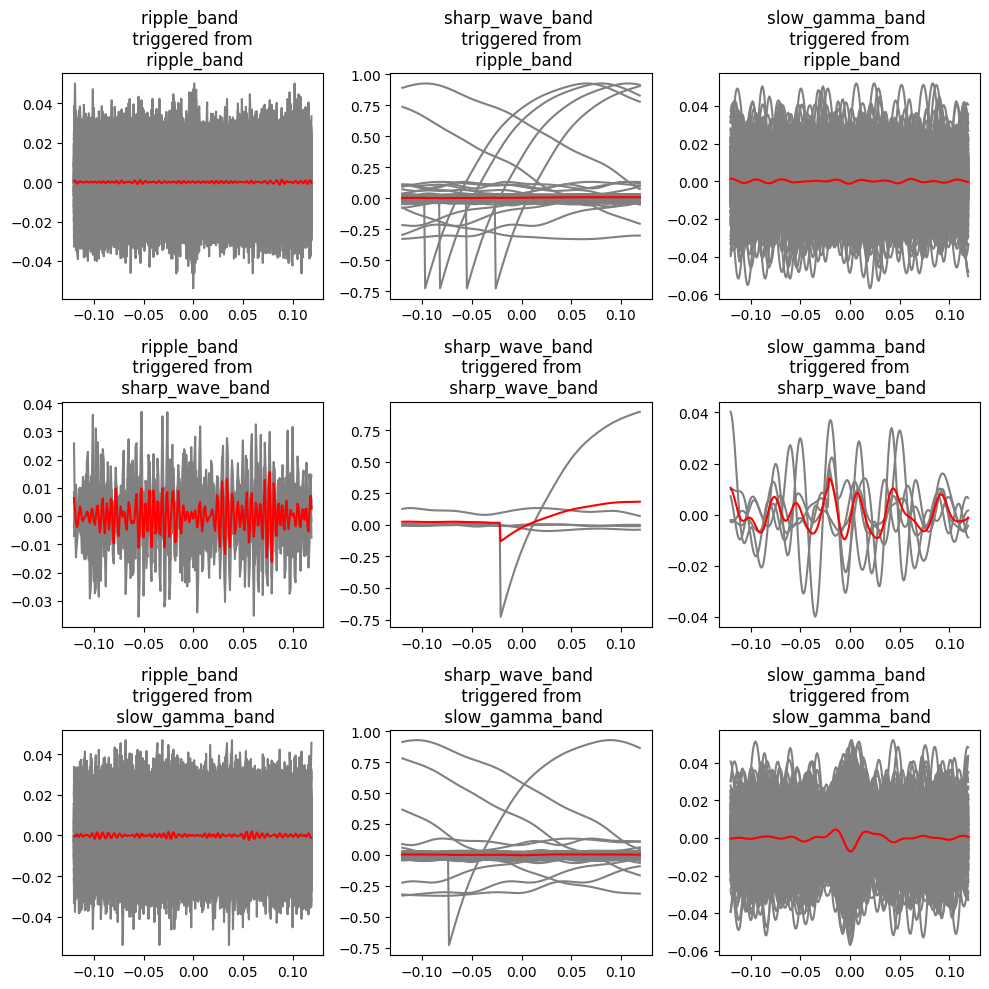

In [37]:
def get_waveforms_stack(waveform,trigs,fs,window_ms=[-150,150]):
    window_s = np.array(window_ms)/fs
    window_tics = np.arange(window_ms[0]/1000*fs,window_ms[1]/1000*fs,1,dtype=int)
    window_time = window_tics/fs
    # fig,ax=plt.subplots(1,1, figsize=(6,4))
    wave_snip_list = []
    for t in trigs:
        try: wave_snip_list.append(waveform[t+window_tics])
        except: None
    wave_snip_stack = np.stack(wave_snip_list,axis=-1)
    # ax.plot(window_tics/fs,wave_snip_stack,'grey')
    # ax.plot(window_tics/fs,np.median(wave_snip_stack,axis=1),'k')
    return wave_snip_stack, window_time


def summarize_trigs(filtered,trig_bands,window_ms=[-120,120]):
    fig,ax = plt.subplots(3,3,figsize=[10,10])
    for b in trig_bands:
        bi = trig_bands.index(b)
        trigs = filtered[b]['trigs']
        for bb in trig_bands:
            bbi = trig_bands.index(bb)
            waveform = filtered[bb]['lfp']
            fs = filtered['fs']
            wave_snip_stack,window_time = get_waveforms_stack(waveform,trigs,fs,window_ms=window_ms)
            ax[bi,bbi].plot(window_time, wave_snip_stack,'grey')
            ax[bi,bbi].plot(window_time, np.mean(wave_snip_stack,1),'r')
            ax[bi,bbi].set_title(f'{bb} \n triggered from \n {b}')
summarize_trigs(filtered,trig_bands,window_ms=[-120,120])
plt.tight_layout()


In [ ]:
# #### Abundance over Time #######
# bin_wid =15

# for f in rip_df.index:
#     fig,ax=plt.subplots(3,figsize=(16,6))
#     fig.suptitle(os.path.basename(f))
#     for ch in chan_list:
#         filtered = rip_df.loc[f,ch]
#         for b in trig_bands:
#             ai = trig_bands.index(b)
#             trigs = filtered[b]['trigs']
#             time_1khz = filtered['time_1khz']
#             ep_0_inds =  rip_df.loc[f,'ep_0_inds']
#             epoch_time = time_1khz - time_1khz[ep_0_inds[-1]]
#             bottom_epo_time = np.floor(np.min(epoch_time)/bin_wid)*bin_wid
#             top_epo_time = np.ceil(np.max(epoch_time)/bin_wid)*bin_wid
#             bins = np.arange(bottom_epo_time,top_epo_time ,bin_wid)
#             t_hist,bin_edges = np.histogram(epoch_time[trigs], bins=bins)
#             numt = len(trigs)
#             # ax.bar(bin_edges[:-1],t_hist/bin_wid,label=f"{b}_{ch} ({numt})",width=8,)
#             ax[ai].plot(bin_edges[:-1],t_hist/bin_wid,'-o',label=f"{b}_{ch} ({numt})",)
#             ax[ai].legend(loc='upper left',bbox_to_anchor=(1, 1, 1, 0))



In [ ]:


# abf = pyabf.ABF('/content/Bumet_ephys_data/2023x07x06_E3KI_F_P525_s3x4_0000.abf')
# freq_bands = time_bands(abf,sweepNumber=0,channel=0)


def plot_abund_ts(time_1khz,trigs,bin_wid=10):
    fig,ax=plt.subplots(1,figsize=(16,4))
    bins = np.arange(0,np.max(time_1khz)+bin_wid,bin_wid)
    hist,edges = np.histogram(time_1khz[trigs], bins=bins)
    ax.bar(bins[1:],hist/bin_wid,width=bin_wid)
    ax.set_ylabel('SW abundance (Hz)')
    plt.show()
    return fig, ax


# trigs_alligned, fig, ax = get_SW_trig_inds(sharp_wave_band,fs,sw_thresh=-4,to_plot=True)

In [ ]:
# # from scipy import signal





# fs = 10000
# w = 6.
# top_freq = fs/2
# top_freq = 600
# freq = np.linspace(1, top_freq, 100)
# freq = np.logspace(np.log2(10), np.log2(top_freq), num=40, endpoint=True, base=2)
# widths = w*fs / (2*freq*np.pi)
# cwtm = scipy.signal.cwt(in0, scipy.signal.morlet2, widths, w=w)

# cw_abs = np.abs(cwtm)
# cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
# cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
# cw_z = (cw_abs - cw_mean) / cw_std





In [ ]:
def inspect_trace(trace,time,line_length=10,start_stop=[],z_scale=3,single_trace_plot_size=[30,2],ax_prev=False,spec_color=False):
    ''' waterfall plot of trace '''
    if len(start_stop) <2: start_stop=[time[0],time[-1]]
    fs = 1/(time[1]-time[0])
    max_t_adj =  np.ceil(start_stop[1]/line_length)*line_length
    pad_width =  int(fs*(max_t_adj) - len(time))
    pad_trace = np.pad(trace,((0,pad_width)),constant_values=(np.nan,np.nan))
    pad_time =  np.pad(time,pad_width,'constant',constant_values=(np.nan,np.nan))

    tics_per_line = int(fs*line_length)
    num_lines = int(len(time)/tics_per_line)+1
    pad_trace_stack = np.reshape(pad_trace,[num_lines,tics_per_line])

    line_time = np.arange(tics_per_line)/fs
    line_time_stack = np.resize(line_time,[num_lines,tics_per_line] )



    y_adjust_const = np.std(trace)*z_scale
    y_adj = y_adjust_const * (np.cumsum(np.ones_like(pad_trace_stack)*-1,axis=0)+1)

    if not ax_prev:
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", np.flip(plt.cm.viridis(np.linspace(0,1,10)),axis=0))
        fig,ax=plt.subplots(figsize=(single_trace_plot_size[0],single_trace_plot_size[1]*num_lines))
    else: (fig,ax) = ax_prev

    if not spec_color: ax.plot(line_time_stack.T,(pad_trace_stack+y_adj).T)
    else: ax.plot(line_time_stack.T,(pad_trace_stack+y_adj).T,color = spec_color)



    from matplotlib.ticker import MultipleLocator
    ax.yaxis.set_minor_locator(MultipleLocator(z_scale/2))

    return fig,ax



In [ ]:
# """ Parse Epochs """
# rip_df['ep_0_inds'] = np.nan
# rip_df['ep_1_inds'] = np.nan
# rip_df['ep_0_inds'] = rip_df['ep_0_inds'].astype(object)
# rip_df['ep_1_inds'] = rip_df['ep_1_inds'].astype(object)

# for f in rip_df.index:

#     # get actual times
#     epoch_0_tag = rip_df.loc[f,'epoch_0']
#     epoch_0_time = epoch_0_tag.split(' ')[1]
#     if ':' in epoch_0_time: int(epoch_0_time.split(':')[0]*60 + epoch_0_time.split(':')[1] )
#     epoch_1_tag = rip_df.loc[f,'epoch_1']
#     if not isinstance(epoch_1_tag,str):
#          epoch_1_time = np.nan
#     else:
#         epoch_1_time = epoch_1_tag.split(' ')[1]
#         if ':' in epoch_1_time:
#             epoch_1_time =  int( epoch_1_time.split(':')[0])*60 + int(epoch_1_time.split(':')[1] )

#     # epoch indicies
#     fs = rip_df.at[f,'ch0']['fs']
#     time = rip_df.at[f,'ch0']['time_1khz']
#     if np.isnan(epoch_1_time):
#         rip_df.at[f,'ep_0_inds'] = np.arange(0,len(time))
#     else:
#         rip_df.at[f,'ep_0_inds'] = np.arange(0, epoch_1_time*fs)
#         rip_df.at[f,'ep_1_inds'] = np.arange(epoch_1_time*fs,len(time))
# display(rip_df.head(5))

,ch0,ch1,epoch_0,epoch_1,ep_0_inds,ep_1_inds
/content/rip_data/2023_07_06/2023x07x06_E3KI_F_P525_s1x2_0000.abf,"{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...","{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...",veh: 0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",NaN
/content/rip_data/2023_07_06/2023x07x06_E3KI_F_P525_s1x2_0001.abf,"{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...","{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...",bmx: 0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",NaN
/content/rip_data/2023_07_06/2023x07x06_E3KI_F_P525_s3x4_0000.abf,"{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...","{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...",veh: 0,bmx: 11:00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[660000, 660001, 660002, 660003, 660004, 66000..."
/content/rip_data/2023_07_06/2023x07x06_E3KI_F_P525_s5x6_0000.abf,"{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...","{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...",veh: 0,bmx: 10:00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[600000, 600001, 600002, 600003, 600004, 60000..."
/content/rip_data/2023_07_07/2023x07x07_E3KI_F_P526_s001_0000.abf,"{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...","{'fs': 1000, 'time_1khz': [0.0, 0.001, 0.002, ...",veh: 0,bmx: 10:00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[600000, 600001, 600002, 600003, 600004, 60000..."
